In [24]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [25]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

In [26]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [27]:
def my_snn_system(devices = "0,1,2,3",
                    my_seed = 42,
                    TIME = 8,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                  ):


    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices

    
    torch.manual_seed(my_seed)


    
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on)
    synapse_fc_out_features = CLASS_NUM


    ## parameter number calculator ##########################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                        past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                    past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ## parameter number calculator ##########################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if pre_trained == False:
        if (convTrue_fcFalse == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                     synapse_fc_trace_const1, synapse_fc_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        else:
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                     synapse_conv_kernel_size, synapse_conv_stride, 
                     synapse_conv_padding, synapse_conv_trace_const1, 
                     synapse_conv_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net)
    else:
        net = torch.load(pre_trained_path)


    net = net.to(device)
    if (net_print == True):
        print(net)
    
    ## param num and memory estimation except BN at MY calculation ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##########################################################################

    criterion = nn.CrossEntropyLoss().to(device)
    # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
    # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler

    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    train_acc_array = np.array([])
    val_acc_now_array = np.array([])
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()
        running_loss = 0.0
        
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)

        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train()

            ## data loading #################################
            inputs, labels = data

            
            if (which_data == 'DVS-CIFAR10'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ################################################# 

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # inputs: [Time, Batch, Channel, Height, Width]   
            inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
            # inputs: [Batch, Time, Channel, Height, Width]   
        
            outputs = net(inputs)

            batch = BATCH 
            if labels.size(0) != BATCH: 
                batch = labels.size(0)

            


            ####### training accruacy print ###############################
            correct = 0
            total = 0
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted[0:batch] == labels).sum().item()
            train_acc = correct / total
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * train_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            training_acc_string = f'{epoch}-{i}/{len(train_loader)} tr_acc: {100 * correct / total:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            
            ################################################################
            

            loss = criterion(outputs[0:batch,:], labels)
            loss.backward()


            ### gradinet verbose ##########################################
            if (gradient_verbose == True):
                if (i % verbose_interval == verbose_interval-1):
                    print('\n\nepoch', epoch, 'iter', i)
                    for name, param in net.named_parameters():
                        if param.requires_grad:
                            print('\n\n\n\n' , name, param.grad)
            ################################################################
            
            optimizer.step()

            running_loss += loss.item()
            # print("Epoch: {}, Iter: {}, Loss: {}".format(epoch + 1, i + 1, running_loss / 100))

            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##############################################
            if i % validation_interval == validation_interval-1:
                iter_one_val_time_start = time.time()
                
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval()
                    for data in test_loader:
                        ## data loading #################################
                        inputs, labels = data

                        
                        if (which_data == 'DVS-CIFAR10'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ################################################# 

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs.permute(1, 0, 2, 3, 4))
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        batch = BATCH 
                        if labels.size(0) != BATCH: 
                            batch = labels.size(0)
                        correct += (predicted[0:batch] == labels).sum().item()
                        val_loss = criterion(outputs[0:batch,:], labels)

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    torch.save(net.state_dict(), "net_save/save_now_net_weights.pth")
                    torch.save(net, "net_save/save_now_net.pth")
                    torch.save(net.module.state_dict(), "net_save/save_now_net_weights2.pth")
                    torch.save(net.module, "net_save/save_now_net2.pth")
            ################################################################
            iterator.set_description(f"train: {training_acc_string}, tr_loss: {loss}, val_acc: {100 * val_acc_now:.2f}%")  

            train_acc_array = np.append(train_acc_array, train_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            train_acc_file_name = f'{base_name}_train_acc_array.npy'
            val_acc_file_name = f'{base_name}_val_acc_now_array.npy'
            np.save(train_acc_file_name, train_acc_array)
            np.save(val_acc_file_name, val_acc_now_array)
            
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        
        
        epoch_time_end = time.time()
        epoch_time = epoch_time_end - epoch_start_time  # 실행 시간 계산
        
        print(f"epoch_time: {epoch_time} seconds")
        print('\n')


In [28]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

my_snn_system(  devices = "0,1,2,3,4,5",
                my_seed = 42,
                TIME = 10, # dvscifar 10 # ottt 6 or 10
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 48, # dvscifar 48 # MNIST 28 # CIFAR10 32

                # DVS-CIFAR10 할거면 time 10으로 해라
                which_data = 'DVS-CIFAR10',# 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS-CIFAR10'
                CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0, # nda 0.5  # ottt 1.0
                lif_layer_v_reset = 0.0, #현재 안씀. 걍 빼기 해버림
                lif_layer_sg_width = 1.0, # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],


                net_print = False, # True # False
                pre_trained_path = "net_save/save_now_net.pth",
                learning_rate = 0.001,  # ottt 0.1  # nda 0.001
                epoch_num = 200,
                verbose_interval = 50, #숫자 크게 하면 꺼짐
                validation_interval = 50, #숫자 크게 하면 꺼짐
                tdBN_on = False,  # True # False
                BN_on = True,  # True # False
                
                surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT

                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling이 낫다.

# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


My Num of PARAMS: 9,404,234, system's param_num : 9,459,274
Memory: 35.87MiB at 32-bit
EPOCH 0


train:   0%|          | 0/71 [00:00<?, ?it/s]

train: 0-48/71 tr_acc: 30.47%, lr=['0.001'], tr_loss: 1.8536916971206665, val_acc: 0.00%:  69%|██████▉   | 49/71 [01:43<00:42,  1.93s/it]

0-49 training acc: 34.38%, lr=['0.001'], val_acc: 0.00%
iter_one_train_time: 1.9208283424377441 seconds, last one_val_time: 0 seconds



train: 0-70/71 tr_acc: 40.00%, lr=['0.001'], tr_loss: 1.5720982551574707, val_acc: 27.20%: 100%|██████████| 71/71 [02:28<00:00,  2.10s/it]

epoch_time: 149.1996715068817 seconds


EPOCH 1



train: 1-48/71 tr_acc: 38.28%, lr=['0.0009990133642141358'], tr_loss: 1.6735680103302002, val_acc: 27.20%:  69%|██████▉   | 49/71 [01:38<00:44,  2.01s/it]

1-49 training acc: 31.25%, lr=['0.0009990133642141358'], val_acc: 27.20%
iter_one_train_time: 1.9900543689727783 seconds, last one_val_time: 2.792165756225586 seconds



train: 1-70/71 tr_acc: 57.50%, lr=['0.0009990133642141358'], tr_loss: 1.498289942741394, val_acc: 23.00%: 100%|██████████| 71/71 [02:24<00:00,  2.03s/it] 

epoch_time: 144.59104919433594 seconds


EPOCH 2



train: 2-48/71 tr_acc: 46.09%, lr=['0.000996057350657239'], tr_loss: 1.515629529953003, val_acc: 23.00%:  69%|██████▉   | 49/71 [01:38<00:43,  2.00s/it] 

2-49 training acc: 39.84%, lr=['0.000996057350657239'], val_acc: 23.00%
iter_one_train_time: 2.15854811668396 seconds, last one_val_time: 2.6522715091705322 seconds



train: 2-70/71 tr_acc: 32.50%, lr=['0.000996057350657239'], tr_loss: 1.6744718551635742, val_acc: 22.30%: 100%|██████████| 71/71 [02:24<00:00,  2.04s/it]

epoch_time: 144.9352765083313 seconds


EPOCH 3



train: 3-48/71 tr_acc: 48.44%, lr=['0.0009911436253643444'], tr_loss: 1.4299664497375488, val_acc: 22.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

3-49 training acc: 46.88%, lr=['0.0009911436253643444'], val_acc: 22.30%
iter_one_train_time: 1.9912052154541016 seconds, last one_val_time: 2.5918898582458496 seconds



train: 3-70/71 tr_acc: 55.00%, lr=['0.0009911436253643444'], tr_loss: 1.3121711015701294, val_acc: 45.00%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.45431327819824 seconds


EPOCH 4



train: 4-48/71 tr_acc: 52.34%, lr=['0.0009842915805643156'], tr_loss: 1.3812373876571655, val_acc: 45.00%:  69%|██████▉   | 49/71 [01:38<00:44,  2.02s/it]

4-49 training acc: 55.47%, lr=['0.0009842915805643156'], val_acc: 45.00%
iter_one_train_time: 1.9722950458526611 seconds, last one_val_time: 2.8068742752075195 seconds



train: 4-70/71 tr_acc: 50.00%, lr=['0.0009842915805643156'], tr_loss: 1.442071557044983, val_acc: 40.20%: 100%|██████████| 71/71 [02:25<00:00,  2.04s/it] 

epoch_time: 145.4476137161255 seconds


EPOCH 5



train: 5-48/71 tr_acc: 50.78%, lr=['0.0009755282581475769'], tr_loss: 1.389562964439392, val_acc: 40.20%:  69%|██████▉   | 49/71 [01:39<00:45,  2.05s/it] 

5-49 training acc: 53.91%, lr=['0.0009755282581475769'], val_acc: 40.20%
iter_one_train_time: 1.9783244132995605 seconds, last one_val_time: 2.579374074935913 seconds



train: 5-70/71 tr_acc: 45.00%, lr=['0.0009755282581475769'], tr_loss: 1.3509461879730225, val_acc: 42.70%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.60790729522705 seconds


EPOCH 6



train: 6-48/71 tr_acc: 64.84%, lr=['0.0009648882429441258'], tr_loss: 1.172792911529541, val_acc: 42.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it] 

6-49 training acc: 53.12%, lr=['0.0009648882429441258'], val_acc: 42.70%
iter_one_train_time: 1.9927432537078857 seconds, last one_val_time: 2.63586688041687 seconds



train: 6-70/71 tr_acc: 60.00%, lr=['0.0009648882429441258'], tr_loss: 1.2162854671478271, val_acc: 51.00%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.41798949241638 seconds


EPOCH 7



train: 7-48/71 tr_acc: 50.00%, lr=['0.0009524135262330099'], tr_loss: 1.3912267684936523, val_acc: 51.00%:  69%|██████▉   | 49/71 [01:38<00:44,  2.00s/it]

7-49 training acc: 43.75%, lr=['0.0009524135262330099'], val_acc: 51.00%
iter_one_train_time: 2.0009446144104004 seconds, last one_val_time: 2.6968271732330322 seconds



train: 7-70/71 tr_acc: 62.50%, lr=['0.0009524135262330099'], tr_loss: 1.2982406616210938, val_acc: 47.40%: 100%|██████████| 71/71 [02:25<00:00,  2.04s/it]

epoch_time: 145.4510407447815 seconds


EPOCH 8



train: 8-48/71 tr_acc: 43.75%, lr=['0.0009381533400219318'], tr_loss: 1.4461992979049683, val_acc: 47.40%:  69%|██████▉   | 49/71 [01:39<00:44,  2.02s/it]

8-49 training acc: 56.25%, lr=['0.0009381533400219318'], val_acc: 47.40%
iter_one_train_time: 1.9843688011169434 seconds, last one_val_time: 2.6771137714385986 seconds



train: 8-70/71 tr_acc: 50.00%, lr=['0.0009381533400219318'], tr_loss: 1.5626710653305054, val_acc: 49.80%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.63080525398254 seconds


EPOCH 9



train: 9-48/71 tr_acc: 46.88%, lr=['0.0009221639627510075'], tr_loss: 1.438058853149414, val_acc: 49.80%:  69%|██████▉   | 49/71 [01:39<00:45,  2.05s/it] 

9-49 training acc: 47.66%, lr=['0.0009221639627510075'], val_acc: 49.80%
iter_one_train_time: 2.0020203590393066 seconds, last one_val_time: 2.6490252017974854 seconds



train: 9-70/71 tr_acc: 55.00%, lr=['0.0009221639627510075'], tr_loss: 1.2909780740737915, val_acc: 41.60%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.625803232193 seconds


EPOCH 10



train: 10-48/71 tr_acc: 51.56%, lr=['0.0009045084971874736'], tr_loss: 1.3257911205291748, val_acc: 41.60%:  69%|██████▉   | 49/71 [01:39<00:44,  2.00s/it]

10-49 training acc: 53.12%, lr=['0.0009045084971874736'], val_acc: 41.60%
iter_one_train_time: 1.976848840713501 seconds, last one_val_time: 2.6647799015045166 seconds



train: 10-70/71 tr_acc: 60.00%, lr=['0.0009045084971874736'], tr_loss: 1.292830228805542, val_acc: 40.90%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.62681365013123 seconds


EPOCH 11



train: 11-48/71 tr_acc: 57.81%, lr=['0.0008852566213878945'], tr_loss: 1.25664222240448, val_acc: 40.90%:  69%|██████▉   | 49/71 [01:38<00:44,  2.01s/it]  

11-49 training acc: 55.47%, lr=['0.0008852566213878945'], val_acc: 40.90%
iter_one_train_time: 2.007190227508545 seconds, last one_val_time: 2.6692819595336914 seconds



train: 11-70/71 tr_acc: 60.00%, lr=['0.0008852566213878945'], tr_loss: 1.3143450021743774, val_acc: 49.60%: 100%|██████████| 71/71 [02:25<00:00,  2.04s/it]

epoch_time: 145.41760659217834 seconds


EPOCH 12



train: 12-48/71 tr_acc: 62.50%, lr=['0.0008644843137107056'], tr_loss: 1.1892037391662598, val_acc: 49.60%:  69%|██████▉   | 49/71 [01:39<00:45,  2.05s/it]

12-49 training acc: 57.03%, lr=['0.0008644843137107056'], val_acc: 49.60%
iter_one_train_time: 1.9990317821502686 seconds, last one_val_time: 2.6406681537628174 seconds



train: 12-70/71 tr_acc: 47.50%, lr=['0.0008644843137107056'], tr_loss: 1.429678201675415, val_acc: 45.50%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it] 

epoch_time: 145.6645998954773 seconds


EPOCH 13



train: 13-48/71 tr_acc: 52.34%, lr=['0.0008422735529643443'], tr_loss: 1.2626564502716064, val_acc: 45.50%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

13-49 training acc: 66.41%, lr=['0.0008422735529643443'], val_acc: 45.50%
iter_one_train_time: 2.0012948513031006 seconds, last one_val_time: 2.699617385864258 seconds



train: 13-70/71 tr_acc: 50.00%, lr=['0.0008422735529643443'], tr_loss: 1.1891169548034668, val_acc: 55.20%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.39263367652893 seconds


EPOCH 14



train: 14-48/71 tr_acc: 58.59%, lr=['0.0008187119948743448'], tr_loss: 1.0966119766235352, val_acc: 55.20%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

14-49 training acc: 58.59%, lr=['0.0008187119948743448'], val_acc: 55.20%
iter_one_train_time: 1.9843196868896484 seconds, last one_val_time: 2.839423656463623 seconds



train: 14-70/71 tr_acc: 60.00%, lr=['0.0008187119948743448'], tr_loss: 1.1495004892349243, val_acc: 56.20%: 100%|██████████| 71/71 [02:25<00:00,  2.06s/it]

epoch_time: 146.1994092464447 seconds


EPOCH 15



train: 15-48/71 tr_acc: 62.50%, lr=['0.0007938926261462366'], tr_loss: 1.122039556503296, val_acc: 56.20%:  69%|██████▉   | 49/71 [01:39<00:45,  2.05s/it] 

15-49 training acc: 64.06%, lr=['0.0007938926261462366'], val_acc: 56.20%
iter_one_train_time: 2.0339977741241455 seconds, last one_val_time: 2.658040761947632 seconds



train: 15-70/71 tr_acc: 52.50%, lr=['0.0007938926261462366'], tr_loss: 1.3050241470336914, val_acc: 52.70%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.93555068969727 seconds


EPOCH 16



train: 16-48/71 tr_acc: 69.53%, lr=['0.0007679133974894982'], tr_loss: 0.9371395111083984, val_acc: 52.70%:  69%|██████▉   | 49/71 [01:39<00:44,  2.00s/it]

16-49 training acc: 61.72%, lr=['0.0007679133974894982'], val_acc: 52.70%
iter_one_train_time: 1.9782583713531494 seconds, last one_val_time: 2.7993221282958984 seconds



train: 16-70/71 tr_acc: 57.50%, lr=['0.0007679133974894982'], tr_loss: 1.3115160465240479, val_acc: 42.30%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.58156442642212 seconds


EPOCH 17



train: 17-48/71 tr_acc: 62.50%, lr=['0.0007408768370508576'], tr_loss: 1.0458348989486694, val_acc: 42.30%:  69%|██████▉   | 49/71 [01:39<00:44,  2.03s/it]

17-49 training acc: 55.47%, lr=['0.0007408768370508576'], val_acc: 42.30%
iter_one_train_time: 2.00361967086792 seconds, last one_val_time: 2.8260974884033203 seconds



train: 17-70/71 tr_acc: 55.00%, lr=['0.0007408768370508576'], tr_loss: 1.1823804378509521, val_acc: 56.50%: 100%|██████████| 71/71 [02:26<00:00,  2.06s/it]

epoch_time: 146.3435652256012 seconds


EPOCH 18



train: 18-48/71 tr_acc: 67.19%, lr=['0.0007128896457825362'], tr_loss: 1.0131752490997314, val_acc: 56.50%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

18-49 training acc: 57.03%, lr=['0.0007128896457825362'], val_acc: 56.50%
iter_one_train_time: 1.9858911037445068 seconds, last one_val_time: 2.7426462173461914 seconds



train: 18-70/71 tr_acc: 62.50%, lr=['0.0007128896457825362'], tr_loss: 1.1318755149841309, val_acc: 56.90%: 100%|██████████| 71/71 [02:26<00:00,  2.07s/it]

epoch_time: 146.95856761932373 seconds


EPOCH 19



train: 19-48/71 tr_acc: 66.41%, lr=['0.0006840622763423389'], tr_loss: 0.9522995948791504, val_acc: 56.90%:  69%|██████▉   | 49/71 [01:38<00:44,  2.00s/it]

19-49 training acc: 64.84%, lr=['0.0006840622763423389'], val_acc: 56.90%
iter_one_train_time: 2.0002758502960205 seconds, last one_val_time: 2.6715097427368164 seconds



train: 19-70/71 tr_acc: 65.00%, lr=['0.0006840622763423389'], tr_loss: 1.0588572025299072, val_acc: 56.90%: 100%|██████████| 71/71 [02:24<00:00,  2.04s/it]

epoch_time: 145.0894272327423 seconds


EPOCH 20



train: 20-48/71 tr_acc: 64.06%, lr=['0.0006545084971874735'], tr_loss: 1.1684849262237549, val_acc: 56.90%:  69%|██████▉   | 49/71 [01:39<00:44,  2.01s/it]

20-49 training acc: 62.50%, lr=['0.0006545084971874735'], val_acc: 56.90%
iter_one_train_time: 1.9815585613250732 seconds, last one_val_time: 2.657740354537964 seconds



train: 20-70/71 tr_acc: 57.50%, lr=['0.0006545084971874735'], tr_loss: 1.1267590522766113, val_acc: 56.80%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.6160545349121 seconds


EPOCH 21



train: 21-48/71 tr_acc: 64.84%, lr=['0.0006243449435824271'], tr_loss: 1.0535260438919067, val_acc: 56.80%:  69%|██████▉   | 49/71 [01:39<00:45,  2.06s/it]

21-49 training acc: 67.97%, lr=['0.0006243449435824271'], val_acc: 56.80%
iter_one_train_time: 1.9902722835540771 seconds, last one_val_time: 2.5966501235961914 seconds



train: 21-70/71 tr_acc: 65.00%, lr=['0.0006243449435824271'], tr_loss: 0.9943377375602722, val_acc: 56.90%: 100%|██████████| 71/71 [02:25<00:00,  2.05s/it]

epoch_time: 145.6301097869873 seconds


EPOCH 22



train: 22-6/71 tr_acc: 65.62%, lr=['0.0005936906572928622'], tr_loss: 0.9878416657447815, val_acc: 56.90%:   8%|▊         | 6/71 [00:14<02:37,  2.42s/it]


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (1569,) and (1568,)

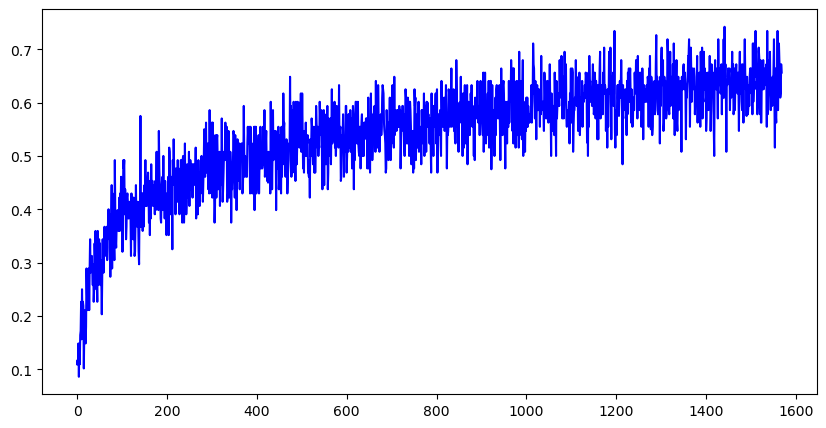

In [29]:
import numpy as np
import matplotlib.pyplot as plt

loaded_train_acc_array = np.load('train_acc_array.npy')
loaded_val_acc_array = np.load('val_acc_now_array.npy')

iterations = np.arange(len(loaded_train_acc_array))

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(iterations, loaded_train_acc_array, label='Training Accuracy', color='b')
plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Iterations')
plt.legend()
plt.grid(True)
plt.show()

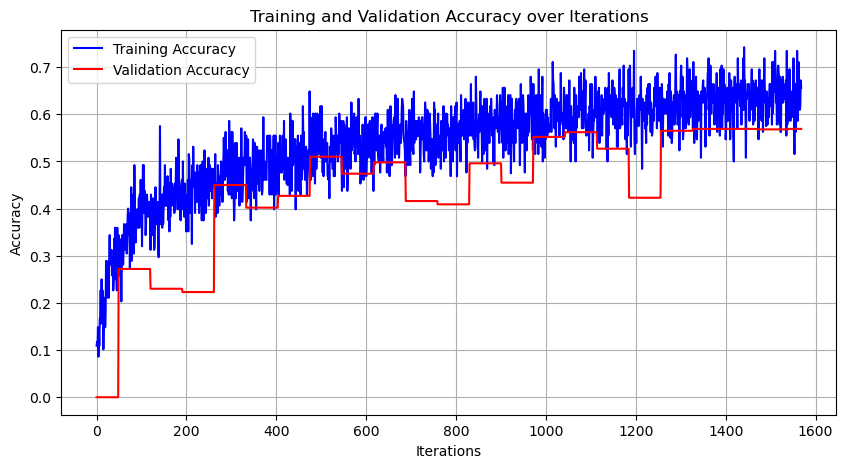

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# current_time = '20240628_110116'
# base_name = f'{current_time}'
# train_acc_file_name = f'{base_name}_train_acc_array.npy'
# val_acc_file_name = f'{base_name}_val_acc_now_array.npy'

# loaded_train_acc_array = np.load(train_acc_file_name)
# loaded_val_acc_array = np.load(val_acc_file_name)

# iterations = np.arange(len(loaded_train_acc_array))


loaded_train_acc_array = np.load('train_acc_array.npy')
loaded_val_acc_array = np.load('val_acc_now_array.npy')
loaded_val_acc_array = np.append(loaded_val_acc_array,0.569)

iterations = np.arange(len(loaded_train_acc_array))

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(iterations, loaded_train_acc_array, label='Training Accuracy', color='b')
plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Iterations')
plt.legend()
plt.grid(True)
plt.show()